In [57]:
# For Reproducable Code
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)

# other standard imports. "pip install -r requirements.txt" to install dependencies and "pip freeze > requirements.txt" to update them
from collections import Counter
import pickle

import PIL
import scipy
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [58]:
# Useful Functions
def pklSave(contentToBeSaved, fullPath):
    with open(fullPath, 'wb') as f:
        pickle.dump(contentToBeSaved, f)

def pklLoad(fullPath, convertToNumpyArray=False):
    with open(fullPath, 'rb') as f:
        content = pickle.load(f)
    if convertToNumpyArray:
        content = np.array(content)
    return content

def train_val_test_split(x, y, tr, va, te, **kwargs):
    x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size=1-tr)
    x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size=te/(te+va), **kwargs)
    return (x_train, x_val, x_test, y_train, y_val, y_test)

# Importing The Dataset

In [59]:
# create generator
datagen = ImageDataGenerator()
# prepare an iterator for the dataset
data_iterator = datagen.flow_from_directory('DatasetOriginal/', class_mode='categorical')
# confirming the iterator works
batchX, batchy = data_iterator.next()
print(f'Batch shape={batchX.shape}, min={batchX.min()}, max={batchX.max()}')

Found 3846 images belonging to 12 classes.
Batch shape=(32, 256, 256, 3), min=0.0, max=255.0


In [60]:
data_iterator.class_indices

{'burj_khalifa': 0,
 'chichen_itza': 1,
 'christ_the_reedemer': 2,
 'eiffel_tower': 3,
 'great_wall_of_china': 4,
 'machu_pichu': 5,
 'pyramids_of_giza': 6,
 'roman_colosseum': 7,
 'statue_of_liberty': 8,
 'stonehenge': 9,
 'taj_mahal': 10,
 'venezuela_angel_falls': 11}

In [61]:
data_iterator.classes, len(data_iterator.classes)

(array([ 0,  0,  0, ..., 11, 11, 11]), 3846)

In [62]:
imgsPerClass = Counter(data_iterator.classes)
print(imgsPerClass.items())

dict_items([(0, 390), (1, 340), (2, 323), (3, 391), (4, 392), (5, 393), (6, 372), (7, 394), (8, 238), (9, 204), (10, 158), (11, 251)])


In [63]:
print(*imgsPerClass.items())

(0, 390) (1, 340) (2, 323) (3, 391) (4, 392) (5, 393) (6, 372) (7, 394) (8, 238) (9, 204) (10, 158) (11, 251)


In [64]:
labels, freq = zip(*imgsPerClass.items())
print(labels, freq)

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11) (390, 340, 323, 391, 392, 393, 372, 394, 238, 204, 158, 251)


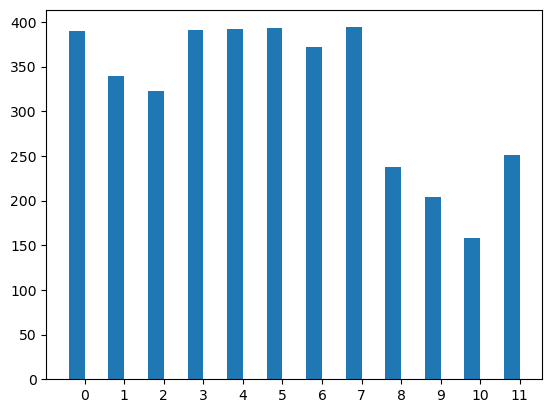

In [65]:
indexes = np.arange(len(labels))
width = 0.4

plt.bar(indexes, freq, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

Due to the class imbalance shown in the bar plot above and due to the limitation of our chosen models (especially the capacity limitation of the HopeField Network), we'll focus only on classes 0, and 3 to 7. <br>
Also, we'll convert the images to grayscale instead of RGB.

In [66]:
data_iterator.class_indices

{'burj_khalifa': 0,
 'chichen_itza': 1,
 'christ_the_reedemer': 2,
 'eiffel_tower': 3,
 'great_wall_of_china': 4,
 'machu_pichu': 5,
 'pyramids_of_giza': 6,
 'roman_colosseum': 7,
 'statue_of_liberty': 8,
 'stonehenge': 9,
 'taj_mahal': 10,
 'venezuela_angel_falls': 11}

In [67]:
newClasses = []
for key, val in data_iterator.class_indices.items():
    if val == 0 or (val >= 3 and val <= 7):
        newClasses.append(key)
newClasses

['burj_khalifa',
 'eiffel_tower',
 'great_wall_of_china',
 'machu_pichu',
 'pyramids_of_giza',
 'roman_colosseum']

# Cleaning Irrelevant Images
Since there are images that barely resembles the actual landmark that we're trying to detect, we'll remove these images and put them in `removed_images` folder <br>
Example of such irrelevant images:
<img src='notebook_media/irrelevant images.png' />
<br><br>
side note: only images in sepecific folders are removed, as in later cells, we'll only consider specific classes

In [68]:
# could use image_dataset_from_directory instead of ImageDataGenerator and flow_from_directory, but since we can't take certain folders (classes) using its arguments, we'll use the depracted method
# ds = image_dataset_from_directory('Dataset/', labels='inferred', label_mode='categorical')
datagen = ImageDataGenerator(rescale=1/255.0) # rescaling the data to convert pixels from range of [0, 255] to [0, 1]
# prepare an iterators for each dataset
data_iterator = datagen.flow_from_directory('Dataset/', classes=newClasses, class_mode='binary', 
                                        target_size=(128,128), seed=42, batch_size=1, color_mode='grayscale', shuffle=False)
# even though our classification problem is not "binary", we're putting it as an argument 
# because we want the labels as they are, as the models will have the task of one-hot encoding them
# batch_size is set to 1, as we want to iterate over each image to flatten it to be used as input for the models
# shuffle is set to False, as we don't want to randomize sampled images in each batch

Found 2081 images belonging to 6 classes.


In [69]:
imgsPerClass = Counter(data_iterator.classes)
print(*imgsPerClass.items())

(0, 285) (1, 360) (2, 356) (3, 360) (4, 360) (5, 360)


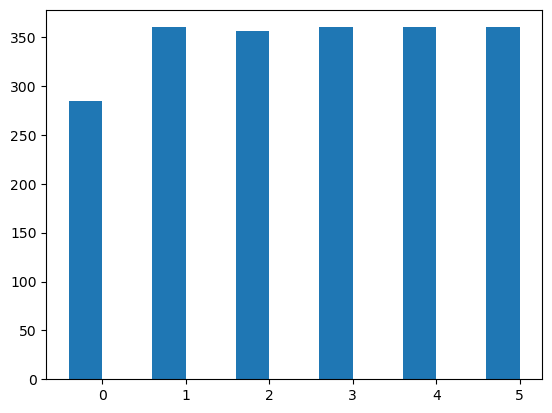

In [70]:
labels, freq = zip(*imgsPerClass.items())
indexes = np.arange(len(labels))
width = 0.4

plt.bar(indexes, freq, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

Due to the relatively high difference in class 0 than the other classes, we'll also remove this class and limit our classification problem to 5 classes

In [71]:
newClasses = []
for key, val in data_iterator.class_indices.items():
    if not val == 0:
        newClasses.append(key)
newClasses

['eiffel_tower',
 'great_wall_of_china',
 'machu_pichu',
 'pyramids_of_giza',
 'roman_colosseum']

In [72]:
data_iterator = datagen.flow_from_directory('Dataset/', classes=newClasses, class_mode='binary', 
                                        target_size=(128,128), seed=42, batch_size=1, color_mode='grayscale', shuffle=False)

Found 1796 images belonging to 5 classes.


(0, 360) (1, 356) (2, 360) (3, 360) (4, 360)


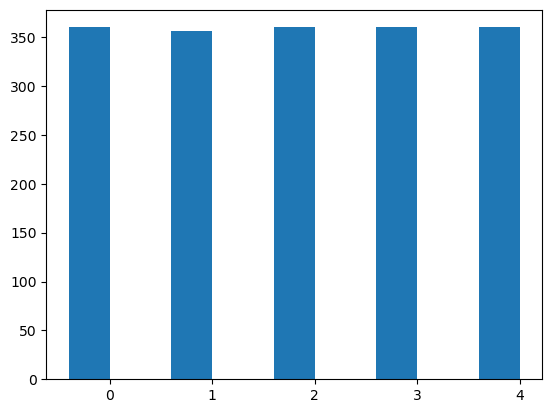

In [73]:
imgsPerClass = Counter(data_iterator.classes)
print(*imgsPerClass.items())

labels, freq = zip(*imgsPerClass.items())
indexes = np.arange(len(labels))
width = 0.4

plt.bar(indexes, freq, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [74]:
for batch in data_iterator: # just for visualizing
    batchofXs = batch[0]
    batchofYs = batch[1]
    print('shape of 1st image:', np.array(batchofXs[0]).shape) 
    print('when flattened:', np.array(batchofXs[0]).flatten().shape)
    print('value of 1st label:', batchofYs[0])
    print('value of 1st image:\n', batchofXs[0])
    break

shape of 1st image: (128, 128, 1)
when flattened: (16384,)
value of 1st label: 0.0
value of 1st image:
 [[[0.78823537]
  [0.7960785 ]
  [0.7960785 ]
  ...
  [0.7686275 ]
  [0.77647066]
  [0.76470596]]

 [[0.7803922 ]
  [0.78823537]
  [0.78823537]
  ...
  [0.78823537]
  [0.78823537]
  [0.7725491 ]]

 [[0.7803922 ]
  [0.7803922 ]
  [0.7803922 ]
  ...
  [0.78823537]
  [0.7803922 ]
  [0.7686275 ]]

 ...

 [[0.4039216 ]
  [0.3921569 ]
  [0.3254902 ]
  ...
  [0.13725491]
  [0.1254902 ]
  [0.09411766]]

 [[0.37254903]
  [0.29411766]
  [0.38431376]
  ...
  [0.14901961]
  [0.08627451]
  [0.08235294]]

 [[0.32156864]
  [0.25882354]
  [0.23137257]
  ...
  [0.09411766]
  [0.07058824]
  [0.0509804 ]]]


In [75]:
x = []
y = []
for i, batch in enumerate(data_iterator):
    if i == data_iterator.samples: # break when all images in the folders are processed
        break
    x.append(np.array(batch[0]).flatten()) # flattening the image
    y.append(int(batch[1])) # converting labels to int instead of float
len(x), len(y)

(1796, 1796)

In [76]:
pklSave(x, 'x128.pkl')
pklSave(y, 'y.pkl')

In [77]:
x = pklLoad('x128.pkl', convertToNumpyArray=True)
y = pklLoad('y.pkl', convertToNumpyArray=True)

In [78]:
x.shape, y.shape

((1796, 16384), (1796,))

The following code will be at the start of each of the models' .ipynb files

In [79]:
# x = pklLoad('../x128.pkl', convertToNumpyArray=True)
# y = pklLoad('../y.pkl', convertToNumpyArray=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [80]:
len(x_train), len(x_test), len(y_train), len(y_test)

(1436, 360, 1436, 360)

# Feature Extraction using PCA
due to the used models' limitation, we'll also use PCA to extract the most important features from each image and store that in another pickle file

On 128x128 version

In [81]:
x.shape

(1796, 16384)

In [82]:
# apply PCA once to
# select the best number of components
pca = PCA(n_components=min(data_iterator.samples, x.shape[1]), random_state=42)
pca.fit(x)

PCA(n_components=1796, random_state=42)

Text(0, 0.5, 'Explained variance')

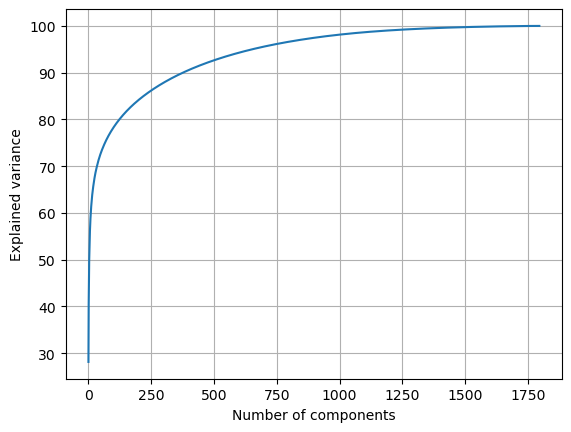

In [83]:
# source: https://towardsdatascience.com/using-pca-to-reduce-number-of-parameters-in-a-neural-network-by-30x-times-fcc737159282
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

As we can see, around 1.4k features make up most of the variance for the images. Therefore, we can only use those features as input to our models!

In [84]:
pca = PCA(n_components=1400, random_state=42)
xfNotNorm = pca.fit_transform(x)

In [85]:
print(xfNotNorm[0][0], xfNotNorm[0][1], np.min(xfNotNorm), np.max(xfNotNorm))

8.782328 14.069367 -58.454586 59.002167


Since the resulted values are not range-bound, they have to be normalized to be from 0 to 1

In [86]:
mmScaler = MinMaxScaler()
xf = mmScaler.fit_transform(xfNotNorm)

In [87]:
# stScaler = StandardScaler()
# xf = stScaler.fit_transform(xfNotNorm)

In [88]:
xf[0]

array([0.57243973, 0.61189944, 0.35332477, ..., 0.6476613 , 0.60316896,
       0.42092118], dtype=float32)

In [89]:
pklSave(xf, 'x128f.pkl')

In [90]:
xf = pklLoad('x128f.pkl', convertToNumpyArray=True)

The following code will be at the start of each of the models' .ipynb files

In [91]:
# xf = pklLoad('../x128f.pkl', convertToNumpyArray=True)
# y = pklLoad('../y.pkl', convertToNumpyArray=True)
x_train, x_test, y_train, y_test = train_test_split(xf, y, test_size=0.2, random_state=42)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## on 64x64 version
Due to the severe loss in information (realized from score on dbn model) that happened when we transformed largely dispersed data to be in [0, 1] scale, we'll try feature extraction on 64x64 version of the dataset

In [92]:
datagen = ImageDataGenerator(rescale=1/255.0)
data_iterator = datagen.flow_from_directory('Dataset/', classes=newClasses, class_mode='binary', 
                                        target_size=(64,64), seed=42, batch_size=1, color_mode='grayscale', shuffle=False)

Found 1796 images belonging to 5 classes.


In [93]:
x64 = []
for i, batch in enumerate(data_iterator):
    if i == data_iterator.samples: # break when all images in the folders are processed
        break
    x64.append(np.array(batch[0]).flatten()) # flattening the image
    # no need to store y values, as shuffle=False in flow_from_directory
len(x64), len(y)

(1796, 1796)

In [94]:
pklSave(x64, 'x64.pkl')

In [95]:
x64 = pklLoad('x64.pkl', convertToNumpyArray=True)

In [96]:
x64.shape, y.shape

((1796, 4096), (1796,))

In [97]:
# apply PCA once to
# select the best number of components
pca = PCA(n_components=min(data_iterator.samples, x64.shape[1]), random_state=42)
pca.fit(x64)

PCA(n_components=1796, random_state=42)

Text(0, 0.5, 'Explained variance')

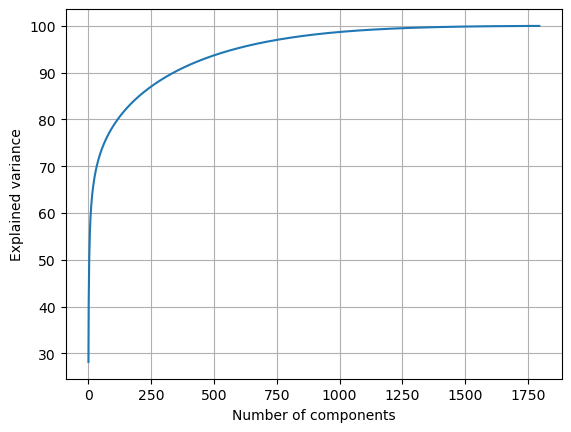

In [98]:
# source: https://towardsdatascience.com/using-pca-to-reduce-number-of-parameters-in-a-neural-network-by-30x-times-fcc737159282
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

As we can see, around 1250 features make up most of the variance for the images. Therefore, we can only use those features as input to our models!

In [99]:
pca = PCA(n_components=1250, random_state=42)
xfNotNorm = pca.fit_transform(x64)

In [100]:
print(xfNotNorm[0][0], xfNotNorm[0][1], np.min(xfNotNorm), np.max(xfNotNorm))

-7.4185038 -0.13402538 -29.328178 29.49172


In [101]:
mmScaler = MinMaxScaler()
x64f = mmScaler.fit_transform(xfNotNorm)

In [102]:
pklSave(x64f, 'x64f.pkl')

In [103]:
x64f = pklLoad('x64f.pkl', convertToNumpyArray=True)

In [104]:
print(x64f[0][0], x64f[0][1], np.min(x64f), np.max(x64f))

0.37248746 0.41806513 0.0 1.0000001


# Trying Data Augmentation
Insufficient data is the main cuase of underfitting that occurred when training the models. Therefore, we'll try augmenting the data

In [105]:
datagen_orig = ImageDataGenerator(rescale=1/255.0)
datagen_flipped = ImageDataGenerator(rescale=1/255.0, horizontal_flip=True)
datagen_zoom = ImageDataGenerator(rescale=1/255.0, zoom_range=0.3)
datagen_shift = ImageDataGenerator(rescale=1/2550.0, width_shift_range=0.2, height_shift_range=0.2)

data_iterator_orig = datagen_orig.flow_from_directory('Dataset/', classes=newClasses, class_mode='binary', 
                                        target_size=(128,128), seed=42, batch_size=1, color_mode='grayscale', shuffle=False)

data_iterator_flipped = datagen_flipped.flow_from_directory('Dataset/', classes=newClasses, class_mode='binary', 
                                        target_size=(128,128), seed=42, batch_size=1, color_mode='grayscale', shuffle=False) 

data_iterator_zoom = datagen_zoom.flow_from_directory('Dataset/', classes=newClasses, class_mode='binary', 
                                        target_size=(128,128), seed=42, batch_size=1, color_mode='grayscale', shuffle=False)

data_iterator_shift = datagen_shift.flow_from_directory('Dataset/', classes=newClasses, class_mode='binary', 
                                        target_size=(128,128), seed=42, batch_size=1, color_mode='grayscale', shuffle=False)                                     

Found 1796 images belonging to 5 classes.
Found 1796 images belonging to 5 classes.
Found 1796 images belonging to 5 classes.
Found 1796 images belonging to 5 classes.


In [106]:
xaug = []
yaug = []
for i, batch in enumerate(data_iterator_orig):
    if i == data_iterator_orig.samples:
        break
    xaug.append(np.array(batch[0]).flatten()) 
    yaug.append(int(batch[1])) 
for i, batch in enumerate(data_iterator_flipped):
    if i == data_iterator_flipped.samples:
        break
    xaug.append(np.array(batch[0]).flatten()) 
    yaug.append(int(batch[1])) 
for i, batch in enumerate(data_iterator_zoom):
    if i == data_iterator_zoom.samples:
        break
    xaug.append(np.array(batch[0]).flatten()) 
    yaug.append(int(batch[1])) 
for i, batch in enumerate(data_iterator_shift):
    if i == data_iterator_zoom.samples:
        break
    xaug.append(np.array(batch[0]).flatten()) 
    yaug.append(int(batch[1])) 

In [107]:
len(xaug), len(yaug)

(7184, 7184)

In [108]:
# sanity check that the exact dataset was passed by 4 times, and therefore classes are distributed properly
imgsPerClass = Counter(data_iterator_orig.classes)
print(*imgsPerClass.items())
print(np.bincount(np.array(yaug)) / 4)
print(np.bincount(np.array(yaug)))

(0, 360) (1, 356) (2, 360) (3, 360) (4, 360)
[360. 356. 360. 360. 360.]
[1440 1424 1440 1440 1440]


In [109]:
pklSave(xaug, 'x128aug.pkl')
pklSave(yaug, 'yaug.pkl')

In [110]:
x128aug = pklLoad('x128aug.pkl', convertToNumpyArray=True)
yaug = pklLoad('yaug.pkl', convertToNumpyArray=True)